In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from utils import QUBO, get_final_ryd_Hamiltonian, show_coords, get_partition_function, find_sic
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import itertools


# For 2x2 cells with 8 atoms

We scan J1 from -0.01 to -0.1, and found that 
1. At certain positions (6/100), the Rydberg system cannot find the correct answer for the QUBO problem
2. For J1 < -0.022, the only solution is all variables take value '1', and Rydberg system can find the correct answer with correct multiplicity
3. For J1 > -0.02, the Rydberg system can find two out of the six solutions. 


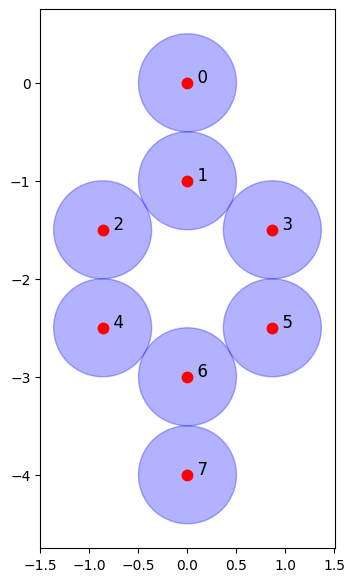

In [4]:
coords = [[0, 0], 
          [0, -1],
          [-np.sqrt(3)/2, -3/2],
          [np.sqrt(3)/2, -3/2],
          [-np.sqrt(3)/2, -5/2],
          [np.sqrt(3)/2, -5/2],
          [0, -3],
          [0, -4],
         ]

neighbors = [
    (0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 6), (6, 7)
]


show_coords(coords)

In [36]:

J1range = [-1/i for i in np.linspace(10, 1e2, 100)]

# for J1 in J1range:
    
#     _, _, _, configs_1, _ = get_final_ryd_Hamiltonian(coords, J1=J1)

#     _, _, _, configs_2 = QUBO(neighbors, J1=J1)

#     configs_3 = [config for config in configs_1 if config in configs_2]
#     print(f"len(configs_1), len(configs_2), len(configs_3) = {len(configs_1)}, {len(configs_2)}, {len(configs_3)}, J1={J1}")

def get_configs_ryd_qubo(J1):
    _, _, _, configs_1, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
    _, _, _, configs_2 = QUBO(neighbors, J1=J1)
    
    return configs_1, configs_2
    
configs = Parallel(n_jobs=-1, backend="loky")(map(delayed(get_configs_ryd_qubo), J1range))

configs_ryd = [config[0] for config in configs]
configs_qubo = [config[1] for config in configs]
configs_overlap = [[config for config in config_ryd if config in config_qubo] 
                   for (config_ryd, config_qubo) in zip(configs_ryd, configs_qubo)]

for config_ryd, config_qubo, config_overlap, J1 in zip(configs_ryd, configs_qubo, configs_overlap, J1range):
    print(f"len(config_ryd), len(config_qubo), len(config_overlap) = {len(config_ryd)}, {len(config_qubo)}, {len(config_overlap)}, J1={J1}")    

len(config_ryd), len(config_qubo), len(config_overlap) = 1, 1, 1, J1=-0.1
len(config_ryd), len(config_qubo), len(config_overlap) = 1, 1, 1, J1=-0.09166666666666667
len(config_ryd), len(config_qubo), len(config_overlap) = 1, 1, 1, J1=-0.08461538461538462
len(config_ryd), len(config_qubo), len(config_overlap) = 1, 1, 1, J1=-0.07857142857142857
len(config_ryd), len(config_qubo), len(config_overlap) = 1, 1, 1, J1=-0.07333333333333333
len(config_ryd), len(config_qubo), len(config_overlap) = 1, 1, 1, J1=-0.06875
len(config_ryd), len(config_qubo), len(config_overlap) = 1, 1, 1, J1=-0.06470588235294118
len(config_ryd), len(config_qubo), len(config_overlap) = 1, 1, 0, J1=-0.06111111111111111
len(config_ryd), len(config_qubo), len(config_overlap) = 1, 1, 1, J1=-0.05789473684210526
len(config_ryd), len(config_qubo), len(config_overlap) = 1, 1, 1, J1=-0.05500000000000001
len(config_ryd), len(config_qubo), len(config_overlap) = 1, 1, 1, J1=-0.05238095238095238
len(config_ryd), len(config_qubo), len

# Comparison of spectrum for J1 = -0.1, -0.061111, -0.02075, -0.015068, -0.01

In [9]:
def compare_spectrum(ryd_H, qubo_H, num_plots=1):
    
    if num_plots==2:
        
        fig, axes = plt.subplots(1, 2, figsize = (12, 6))

        axes[0].plot(ryd_H, '.')
        axes[1].plot(qubo_H, '.')
        axes[0].set_title(f"Spectrum of Rydberg Ham for J1={J1}")
        axes[1].set_title(f"Spectrum of QUBO for J1={J1}")
        axes[0].set_ylabel("energy")
        axes[0].set_xlabel("states")
        axes[1].set_xlabel("states")
        axes[0].grid()
        axes[1].grid()
        plt.show()
        
    elif num_plots==1:
        plt.figure(figsize=(12,6))
        ryd_H_scaled = ryd_H / (max(ryd_H) - min(ryd_H)) * (max(qubo_H) - min(qubo_H))
        plt.plot(ryd_H_scaled, '.', label="Rydberg Ham")
        plt.plot(qubo_H, '.', label="QUBO")
        plt.title(f"Spectrum for J1={J1}")
        plt.xlabel("states")
        plt.ylabel("energy")
        plt.legend()
        plt.grid()
        plt.show()
        
def get_boltzmann_distribution(energies, T=298.15, return_pi=True):
    num_atoms = int(np.log2(len(energies)))
    
    if num_atoms == 8:
        atom_indices = np.loadtxt('data/atom_indices_8_no_pbc.csv', delimiter=",").astype(np.int64)
    elif num_atoms == 18:
        atom_indices = np.loadtxt('data/atom_indices_18_no_pbc.csv', delimiter=",").astype(np.int64)
    
    configurations = np.array(list(itertools.product([0, 1], repeat=num_atoms)))
    
    config_unique, unique_energies, multiplicity = find_sic(configurations, energies, atom_indices)
        
    Z, p_i = get_partition_function(unique_energies, multiplicity, T=T, return_pi=return_pi)
    
    return Z, p_i
    
def compare_boltzmann_distribution(ryd_H, qubo_H, num_plots=2, T=298.15, return_pi=True):
    
    ryd_H_scaled = ryd_H / (max(ryd_H) - min(ryd_H)) * (max(qubo_H) - min(qubo_H))
    ryd_Z, ryd_p_i = get_boltzmann_distribution(ryd_H_scaled, T=T, return_pi=return_pi)
    qubo_Z, qubo_p_i = get_boltzmann_distribution(qubo_H, T=T, return_pi=return_pi)
    
    print("boltzmann_distributions got")
    
    if num_plots==2:
        
        fig, axes = plt.subplots(1, 2, figsize = (12, 6))

        axes[0].bar(np.arange(len(ryd_p_i)), ryd_p_i, label=f"Z = {ryd_Z}")
        axes[1].bar(np.arange(len(qubo_p_i)), qubo_p_i, label=f"Z = {qubo_Z}")
        axes[0].set_title(f"Boltzmann distribution of Rydberg Ham for J1={J1}")
        axes[1].set_title(f"Boltzmann distribution of QUBO for J1={J1}")
        axes[0].set_ylabel("Probability")
        axes[0].set_xlabel("SIC index")
        axes[1].set_xlabel("SIC index")
        axes[0].legend()
        axes[1].legend()
        axes[0].grid()
        axes[1].grid()
        plt.show()
        
    elif num_plots==1:
        fig, axs = plt.subplots(1, 1, figsize = (12, 6))
        axs.bar(np.arange(len(ryd_p_i)),ryd_p_i, label="Rydberg")
        axs.bar(np.arange(len(qubo_p_i)),qubo_p_i, label="QUBO")
        
        plt.title(f"Boltzmann distribution for J1={J1}")
        plt.xlabel("SIC index")
        plt.ylabel("Probability")
        plt.legend()
        plt.grid()
        plt.show()
    
    

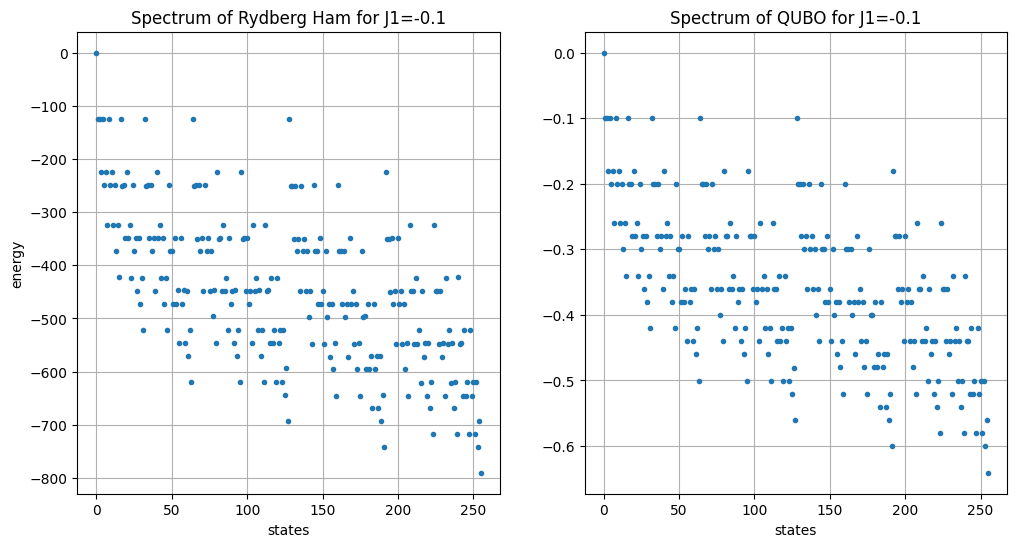

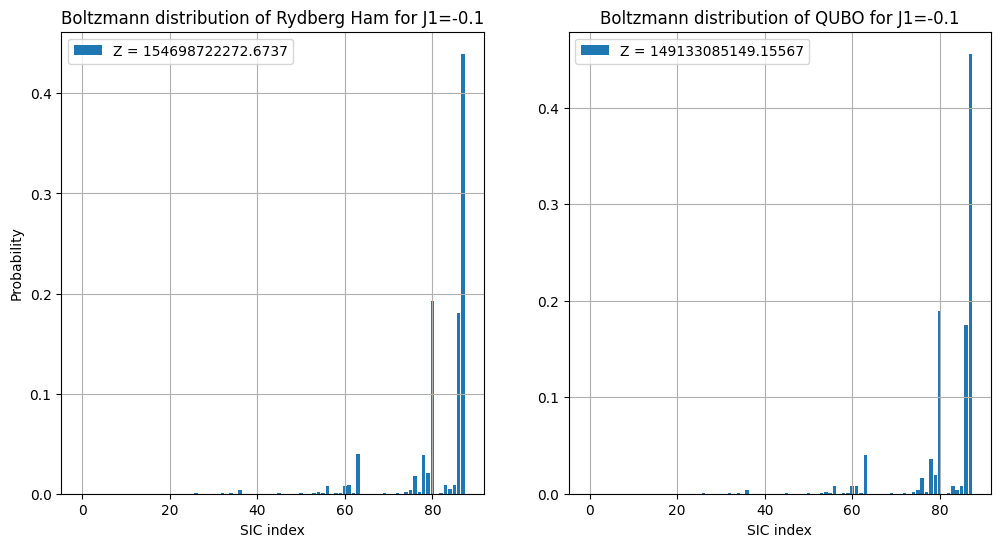

In [74]:
J1 = -0.1
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)
compare_boltzmann_distribution(ryd_H, qubo_H, num_plots=2)

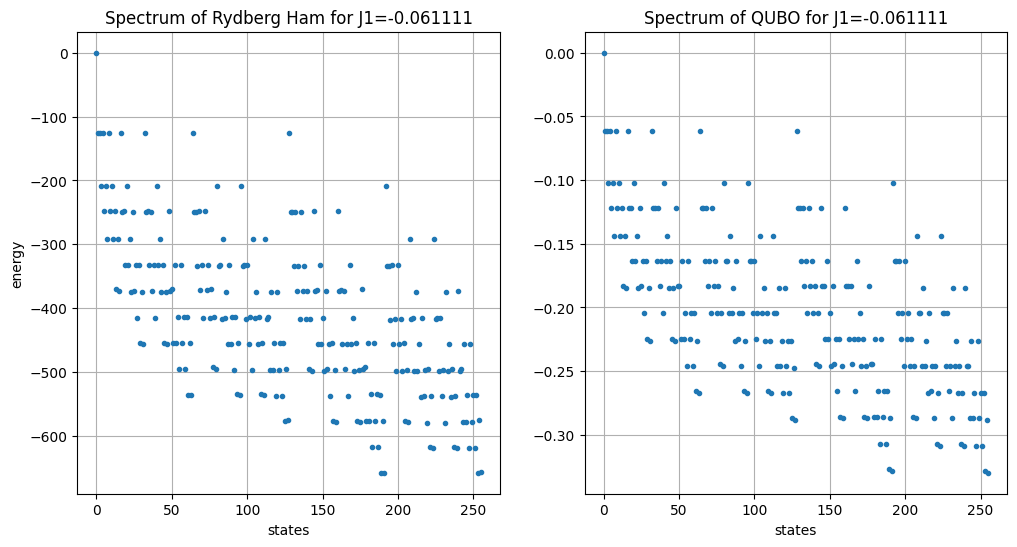

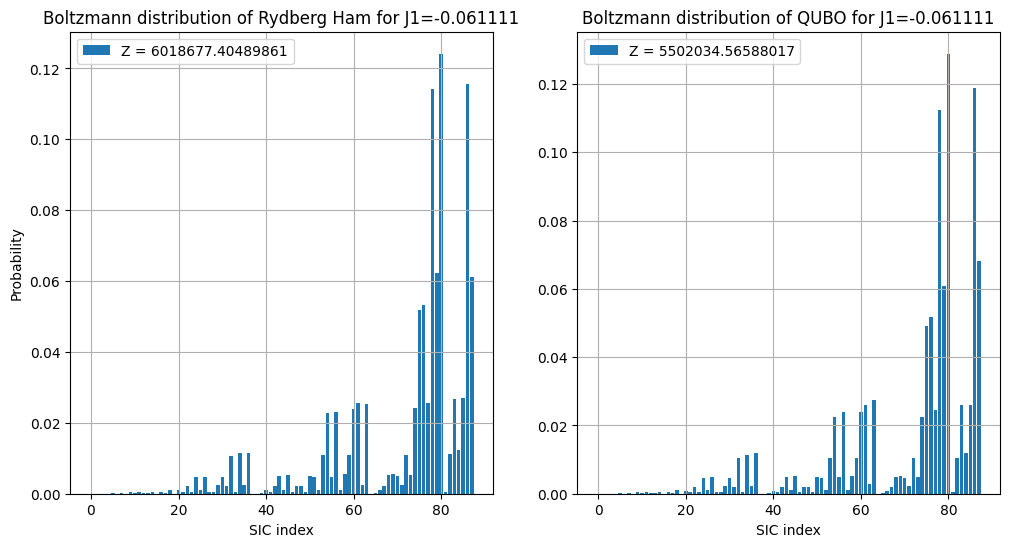

In [75]:
J1 = -0.061111
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)
compare_boltzmann_distribution(ryd_H, qubo_H, num_plots=2)

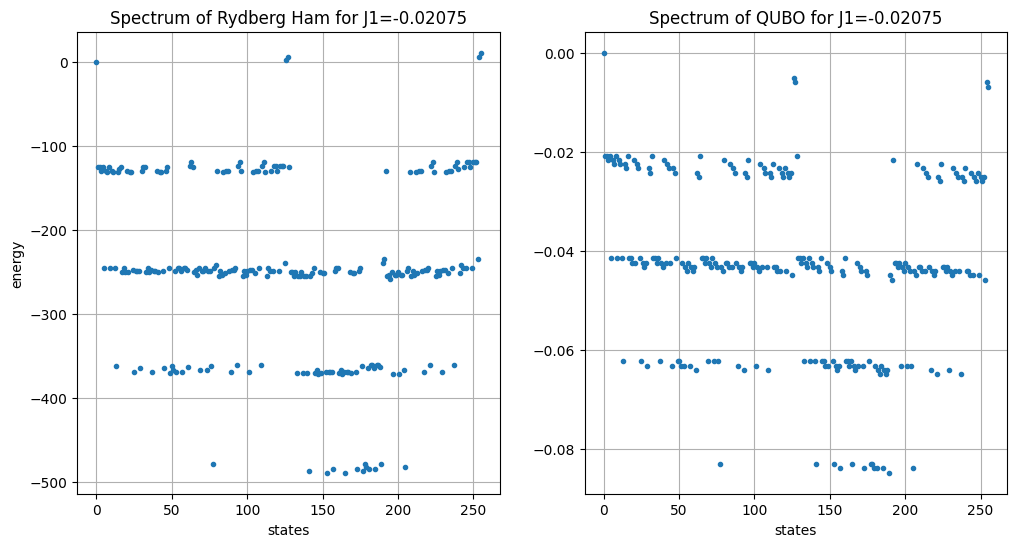

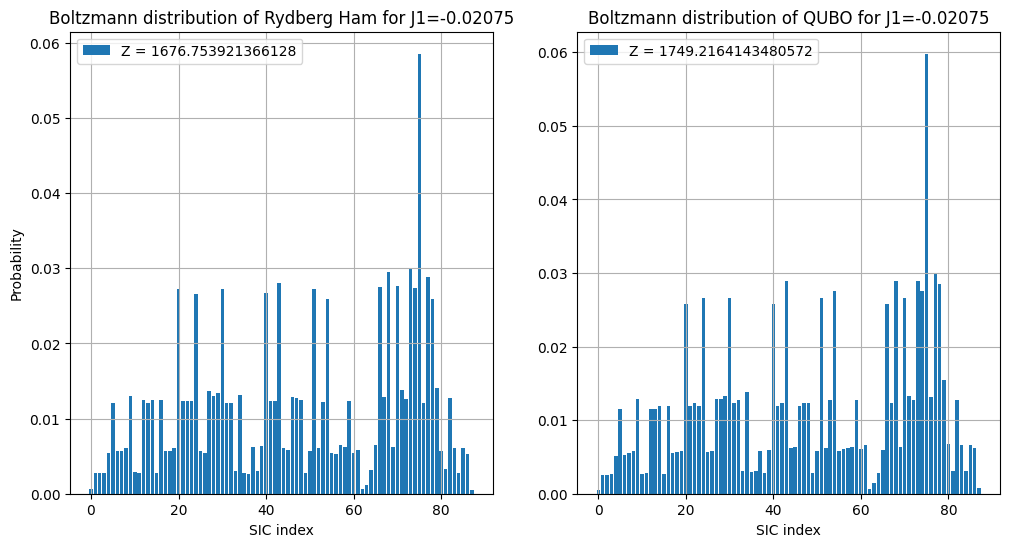

In [76]:
J1 = -0.02075
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)
compare_boltzmann_distribution(ryd_H, qubo_H, num_plots=2)

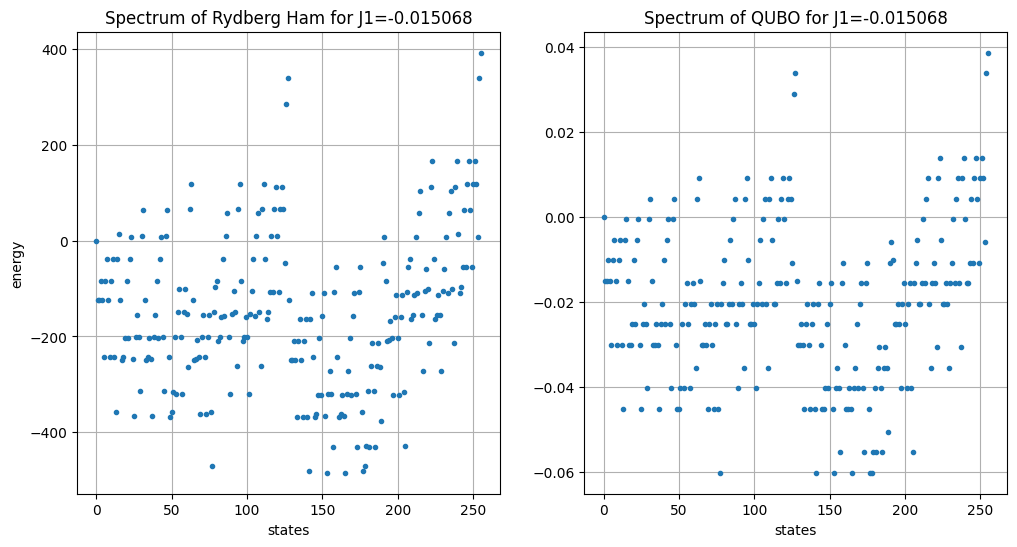

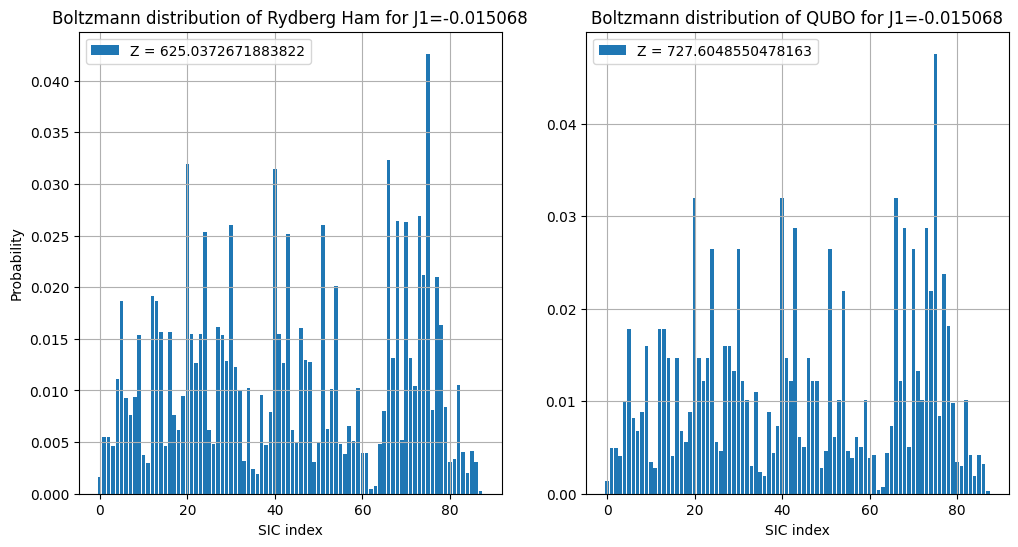

In [77]:
J1 = -0.015068
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)
compare_boltzmann_distribution(ryd_H, qubo_H, num_plots=2)

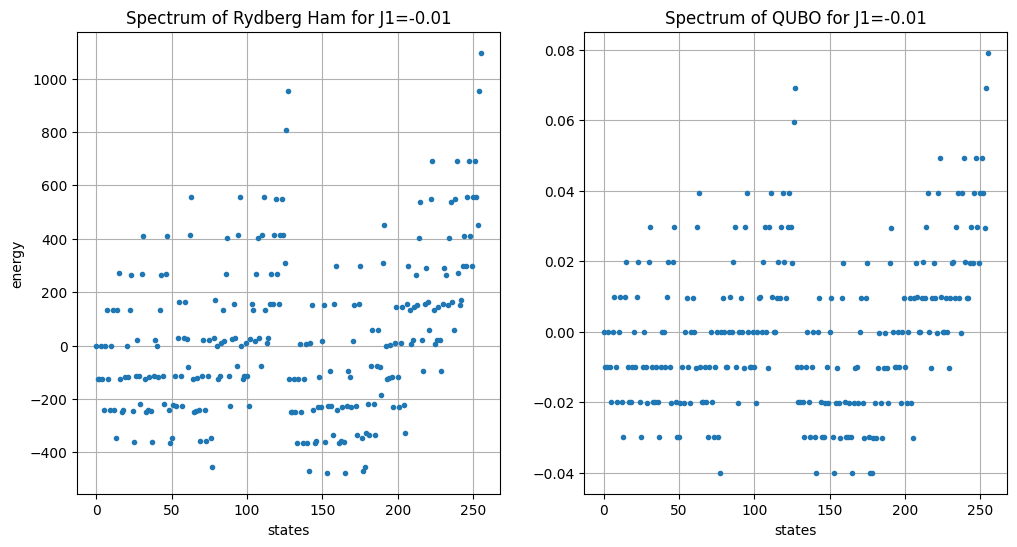

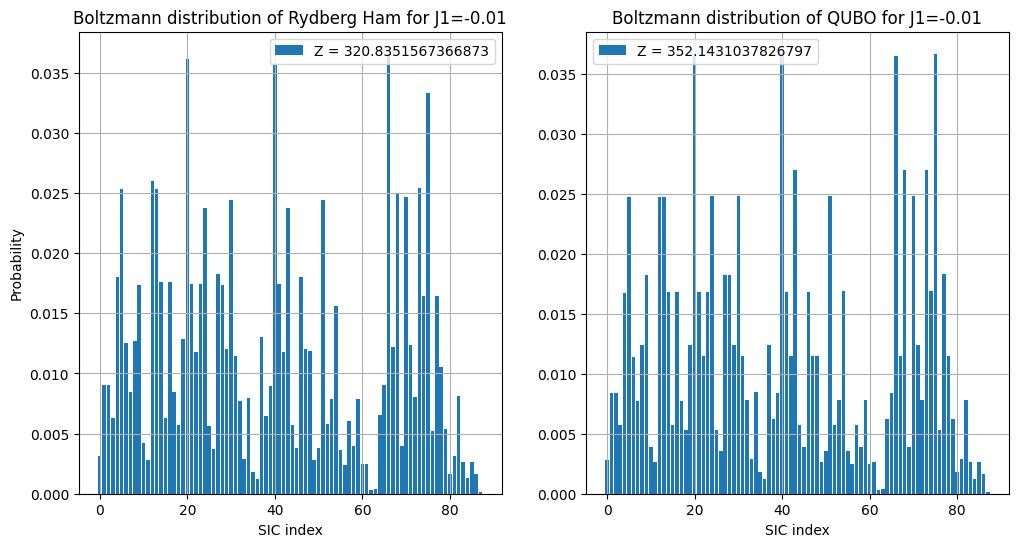

In [78]:
J1 = -0.01
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)
compare_boltzmann_distribution(ryd_H, qubo_H, num_plots=2)

# For 3x3 cells with 27 atoms

We scan J1 from -0.01 to -0.1, and found that 

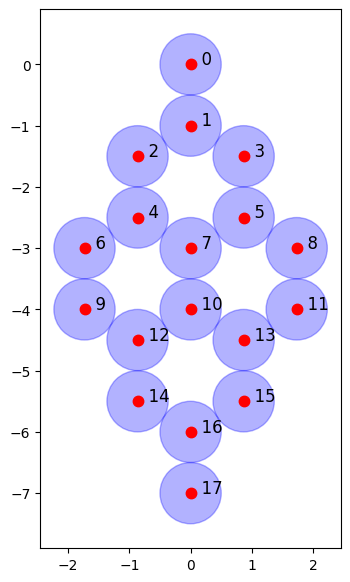

In [6]:
coords = [[0, 0], 
          [0, -1],
          [-np.sqrt(3)/2, -3/2],
          [np.sqrt(3)/2, -3/2],
          [-np.sqrt(3)/2, -5/2],
          [np.sqrt(3)/2, -5/2],
          [-np.sqrt(3), -3],
          [0, -3],
          [np.sqrt(3), -3],
          [-np.sqrt(3), -4],
          [0, -4],
          [np.sqrt(3), -4],
          [-np.sqrt(3)/2, -9/2],
          [np.sqrt(3)/2, -9/2],
          [-np.sqrt(3)/2, -11/2],
          [np.sqrt(3)/2, -11/2],                    
          [0, -6],
          [0, -7],
         ]

neighbors = [
    (0, 1), 
    (1, 2), (1, 3), 
    (2, 4), (3, 5), 
    (4, 6), (4, 7), (5, 7), (5, 8),
    (6, 9), (7, 10), (8, 11),
    (9, 12), (10, 12), (10, 13), (11, 13),
    (12, 14), (13, 15),
    (14, 16), (15, 16),
    (16, 17)
]

show_coords(coords)

In [6]:
J1range = [-1/i for i in np.linspace(10, 1e2, 100)]

# for J1 in J1range:
    
#     _, _, _, configs_1, _ = get_final_ryd_Hamiltonian(coords, J1=J1)

#     _, _, _, configs_2 = QUBO(neighbors, J1=J1)

#     configs_3 = [config for config in configs_1 if config in configs_2]
#     print(f"len(configs_1), len(configs_2), len(configs_3) = {len(configs_1)}, {len(configs_2)}, {len(configs_3)}, J1={J1}")

def get_configs_ryd_qubo(J1):
    _, _, _, configs_1, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
    _, _, _, configs_2 = QUBO(neighbors, J1=J1)
    
    return configs_1, configs_2
    
configs = Parallel(n_jobs=-1, backend="loky")(map(delayed(get_configs_ryd_qubo), J1range))

configs_ryd = [config[0] for config in configs]
configs_qubo = [config[1] for config in configs]
configs_overlap = [[config for config in config_ryd if config in config_qubo] 
                   for (config_ryd, config_qubo) in zip(configs_ryd, configs_qubo)]

for config_ryd, config_qubo, config_overlap, J1 in zip(configs_ryd, configs_qubo, configs_overlap, J1range):
    print(f"len(config_ryd), len(config_qubo), len(config_overlap) = {len(config_ryd)}, {len(config_qubo)}, {len(config_overlap)}, J1={J1}")    

len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.1
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.09166666666666667
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.08461538461538462
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.07857142857142857
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.07333333333333333
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.06875
len(configs_1), len(configs_2), len(configs_3) = 2, 1, 0, J1=-0.06470588235294118
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 0, J1=-0.06111111111111111
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05789473684210526
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05500000000000001
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05238095238095238
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J1=-0.05
len(configs_1), len(configs_2), len(configs_3) = 1, 1, 1, J

# Comparison of spectrum for J1 = -0.1, -0.061111, -0.02075, -0.015068, -0.01

boltzmann_distributions got


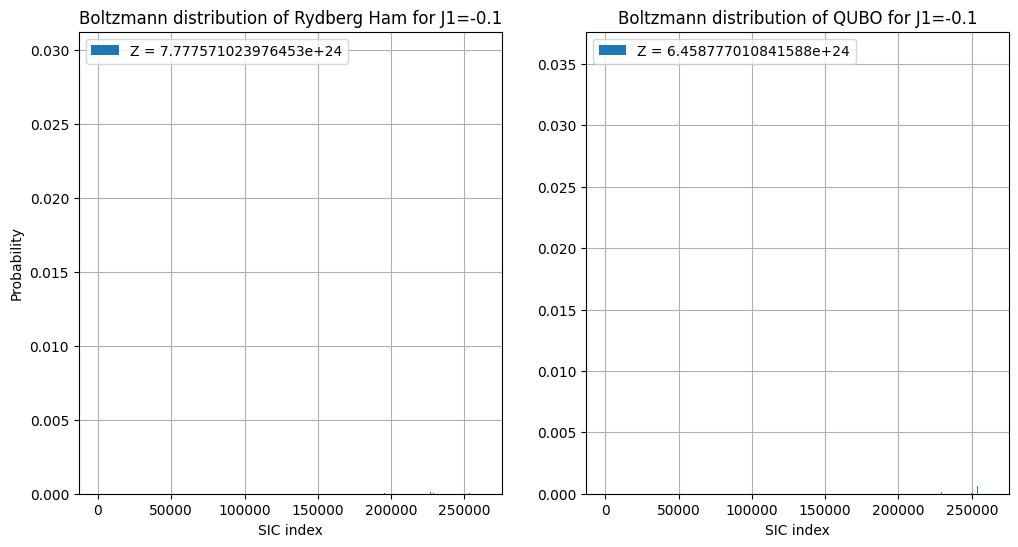

In [10]:
J1 = -0.1
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

# compare_spectrum(ryd_H, qubo_H, num_plots=2)
compare_boltzmann_distribution(ryd_H, qubo_H, num_plots=2)

In [ ]:
J1 = -0.061111
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)
compare_boltzmann_distribution(ryd_H, qubo_H, num_plots=2)

In [ ]:
J1 = -0.02075
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)
compare_boltzmann_distribution(ryd_H, qubo_H, num_plots=2)

In [ ]:
J1 = -0.015068
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)
compare_boltzmann_distribution(ryd_H, qubo_H, num_plots=2)

In [ ]:
J1 = -0.01
ryd_H, _, _, _, _ = get_final_ryd_Hamiltonian(coords, J1=J1)
qubo_H, _, _, _ = QUBO(neighbors, J1=J1)

compare_spectrum(ryd_H, qubo_H, num_plots=2)
compare_boltzmann_distribution(ryd_H, qubo_H, num_plots=2)